# All imports

In [2]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, pairwise_distances_argmin_min, mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import statsmodels.api as sm
import scipy as sc
from scipy.stats import multivariate_t, t, multivariate_normal
from scipy.special import loggamma
import sys


# Regression problem

We will use the diamonds dataset to explore Bayesian non-parametric methods for regression, namely Gaussian Processes Regression. We will aim to predict the prices of diamonds using the provided features.

## Dataset exploration

### Loading Dataset

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
df = pd.read_csv('diamonds.csv')

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Analysing dataset

In [3]:
class Plotter():
    def __init__(self, data):
        self.data = data
        pass
    
    def plot(self, x, y, plt_type):
        if plt_type == 'scatter':
            plt.scatter(self.data[x], self.data[y])
        if plt_type == 'box':
            sns.boxplot(data=self.data, x=x, y=y)
        plt.title(f"{x} against {y}")
        plt.show()
 
pltr = Plotter(df)

#### Correlation Matrix of numerical features

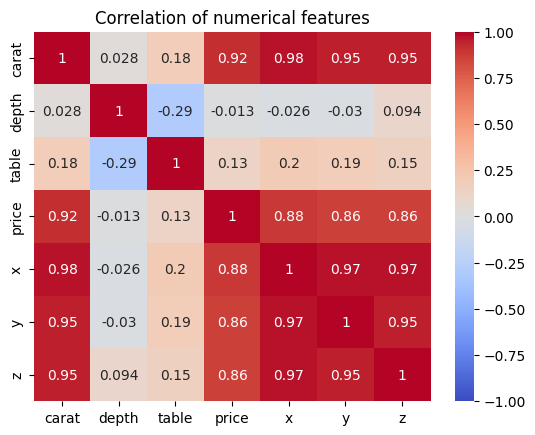

In [4]:
corr = df.select_dtypes(include='number').corr()
plt.figure() 
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of numerical features')
plt.show()

#### Scatter plot of low correlated features

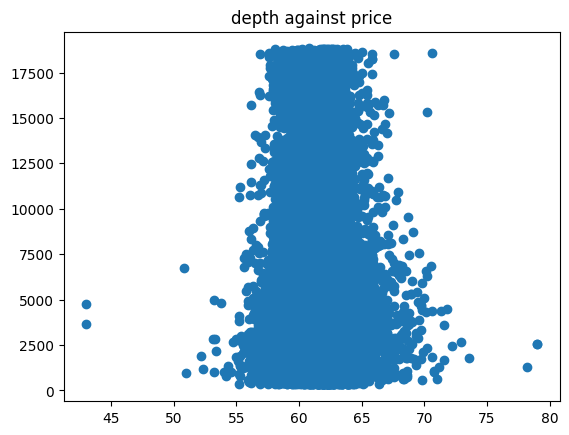

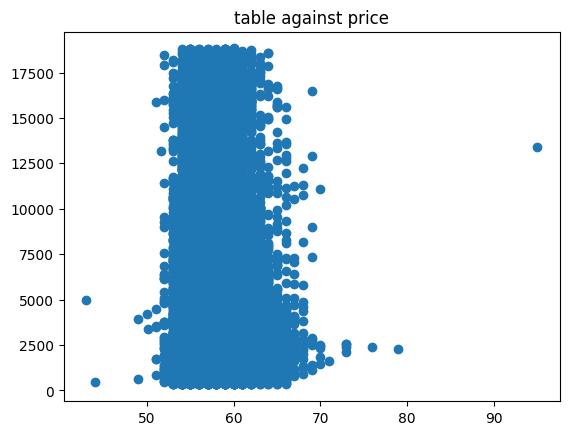

In [7]:
pltr.plot('depth', 'price', 'scatter')
pltr.plot('table', 'price', 'scatter')

#### Scatter plot of highly correlated features

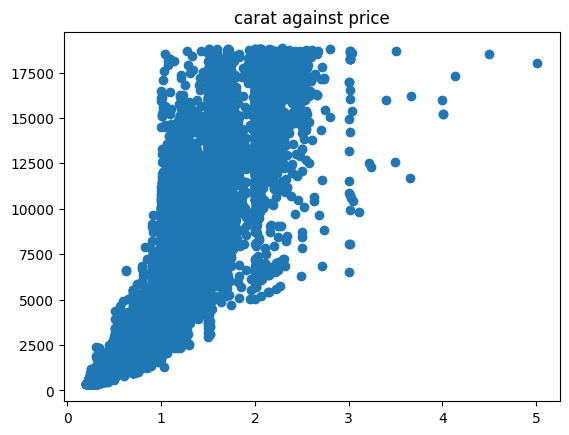

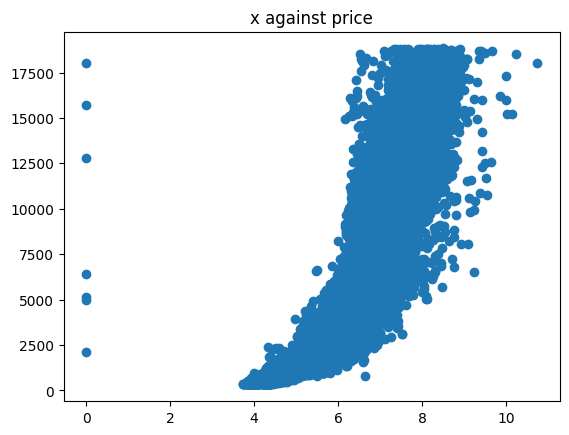

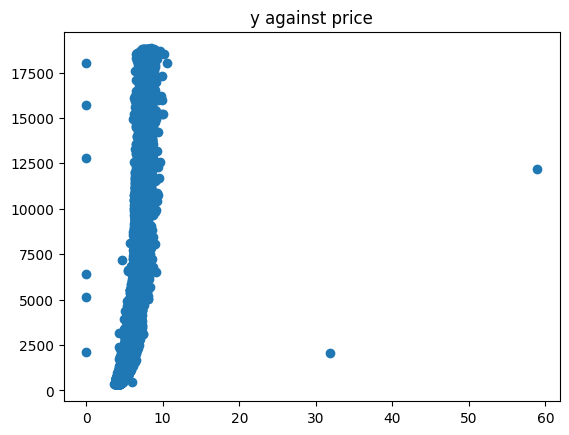

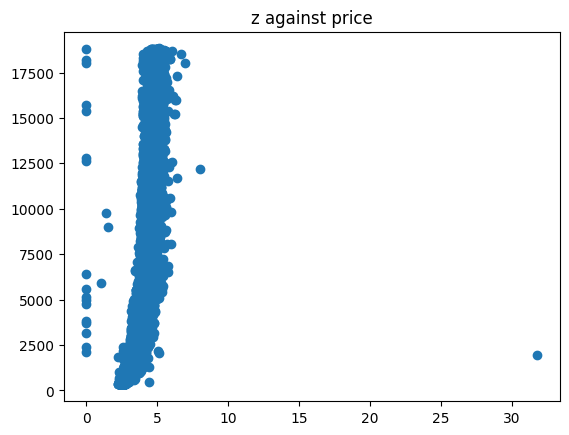

In [8]:
pltr.plot('carat', 'price', 'scatter')
pltr.plot('x', 'price', 'scatter')
pltr.plot('y', 'price', 'scatter')
pltr.plot('z', 'price', 'scatter')

#### Categorical/Ordinal feature analysis

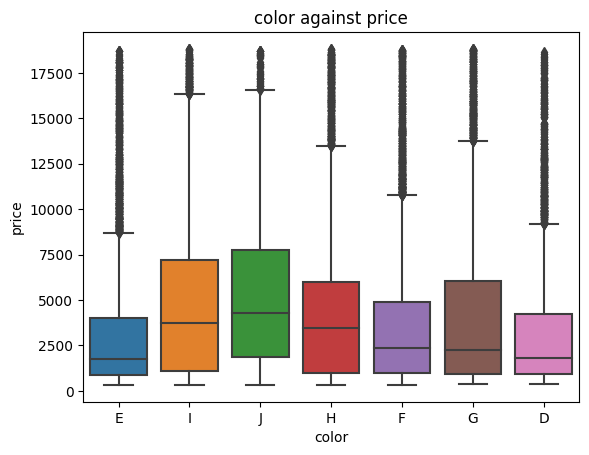

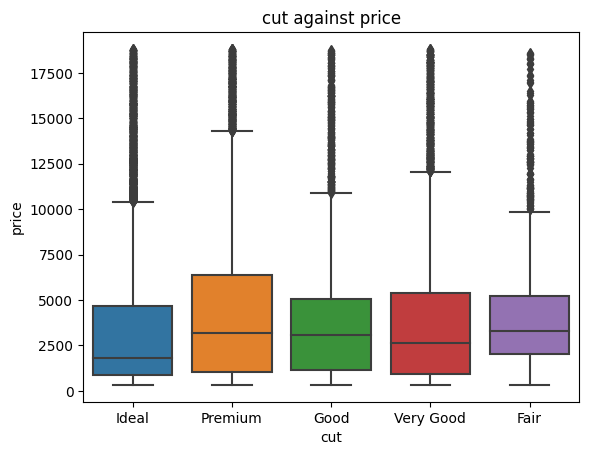

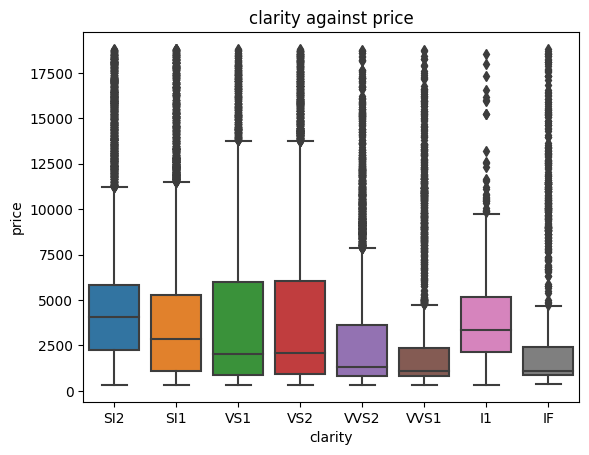

In [9]:
pltr.plot('color', 'price', 'box')
pltr.plot('cut', 'price', 'box')
pltr.plot('clarity', 'price', 'box')

## Dataset Splitting

In [10]:
X = df.drop(columns=['price'])
y = df['price']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle=True, random_state=2)

## Dataset Preprocessing

### Preprocessing Classes

In [11]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, subset=None, keep='first'):
        self.subset = subset
        self.keep = keep
        
    def reset_indices(self, X_cleaned, y_cleaned):
        return X_cleaned.reset_index(drop = True), y_cleaned.reset_index(drop = True)
    
    def get_list_of_similar_pairs(self, X):
        distance_matrix = euclidean_distances(X[['x', 'y', 'z']])
        threshold = 1e-3
        near_duplicate_pairs = np.argwhere(distance_matrix < threshold)
        filtered_pairs = [(i, j) for i, j in near_duplicate_pairs if i < j]
        
        rows_to_remove = set()
        for i,j in filtered_pairs:
            if i not in rows_to_remove and j not in rows_to_remove:
                rows_to_remove.add(j)
        
        return rows_to_remove

    def get_n_samples(self, X, n):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(X[['x', 'y', 'z', 'carat', 'depth', 'table']])
        indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X[['x', 'y', 'z', 'carat', 'depth', 'table']])
        return indices
        
    def filter(self, X_cleaned, y_cleaned, n):
        # Filter to get only 1500 data points as GP regression can't handle a lot of data
        indices_to_keep = self.get_n_samples(X_cleaned, n)
        X_cleaned = X_cleaned.iloc[indices_to_keep]
        y_cleaned = y_cleaned.iloc[indices_to_keep]
        X_cleaned, y_cleaned = self.reset_indices(X_cleaned, y_cleaned) 
        return X_cleaned, y_cleaned
        
    def remove_rows_with_faulty_diamond_size(self, X_cleaned, y_cleaned):
        mask_nonzero = ~((X_cleaned['x'] == 0) | (X_cleaned['y'] == 0) | (X_cleaned['z'] == 0))
        X_cleaned = X_cleaned[mask_nonzero]
        y_cleaned = y_cleaned.loc[X_cleaned.index]
        X_cleaned, y_cleaned = self.reset_indices(X_cleaned, y_cleaned) 
        return X_cleaned, y_cleaned
    
    def remove_duplicates(self, X, y):
        X_cleaned = X.drop_duplicates(subset=self.subset, keep=self.keep)
        y_cleaned = y.loc[X_cleaned.index]
        X_cleaned, y_cleaned = self.reset_indices(X_cleaned, y_cleaned) 
        return X_cleaned, y_cleaned
        
    def fit(self, X, y):
        return self

    def transform(self, X, y, filt = False, cols_to_drop = []):
        # Remove duplicate rows
        X_cleaned, y_cleaned = self.remove_duplicates(X, y)

        # Remove redundant data i.e. dimension of diamond is 0
        X_cleaned, y_cleaned = self.remove_rows_with_faulty_diamond_size(X_cleaned, y_cleaned)

        # Filter to get only 1500 items
        if filt:
            X_cleaned, y_cleaned = self.filter(X_cleaned, y_cleaned, 1500)
        
        # Drop certain features which are deemed unnecessary
        if len(cols_to_drop) > 0:
            X_cleaned = X_cleaned.drop(labels = cols_to_drop, axis = 1)
 
        return X_cleaned, y_cleaned
   
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y) 


ordinal_cols = ['cut', 'color', 'clarity']
ordinal_categories = [
    ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
    ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
]
numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
numeric_cols = ['carat', 'depth', 'table']

preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
    # ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ordinal_cols),
    ('num', StandardScaler(), numeric_cols)
], remainder='passthrough')


full_pipeline = Pipeline([
    ('preprocess', preprocessor),
    # ('model', RandomForestRegressor())
])

#### Cleaning and Preprocessing the data

In [12]:
dc = DataCleaner()
X_train_cleaned, y_train_cleaned = dc.transform(X = X_train, y = y_train, cols_to_drop=['x','y','z'])
X_val_cleaned , y_val_cleaned = dc.transform(X = X_val, y = y_val, cols_to_drop=['x','y','z'])
X_test_cleaned , y_test_cleaned = dc.transform(X = X_test, y = y_test, cols_to_drop=['x','y','z'])

X_train_preprocessed = full_pipeline.fit_transform(X_train_cleaned, y_train_cleaned)
X_val_preprocessed = full_pipeline.fit_transform(X_val_cleaned, y_val_cleaned)
X_test_preprocessed = full_pipeline.fit_transform(X_test_cleaned, y_test_cleaned)

print("Training:")
print(X_train_preprocessed.shape)
print(y_train_cleaned.shape)
print("\nValidation")
print(X_val_preprocessed.shape)
print(y_val_cleaned.shape)
print("\nTesting:")
print(X_test_preprocessed.shape)
print(y_test_cleaned.shape)

Training:
(29892, 6)
(29892,)

Validation
(9982, 6)
(9982,)

Testing:
(9984, 6)
(9984,)


### Gaussian Process Simulation and Visualization 

In [14]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb,sigma,ell):
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * cdist(xa, xb, 'sqeuclidean')/ell
    return sigma * sigma * np.exp(sq_norm)

In [15]:
kernel = ConstantKernel(constant_value=1) * RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000)) + WhiteKernel(noise_level=0.1 ** 2, noise_level_bounds=(1e-5, 1e+5))
covariance_matrix = exponentiated_quadratic(np.expand_dims(sorted(X_train_preprocessed[0:200, -3]), 1), np.expand_dims(sorted(X_train_preprocessed[0:200, -3]), 1), 1, 1)
ys = np.random.multivariate_normal(
    mean=np.zeros(200), cov=covariance_matrix, 
    size=1)

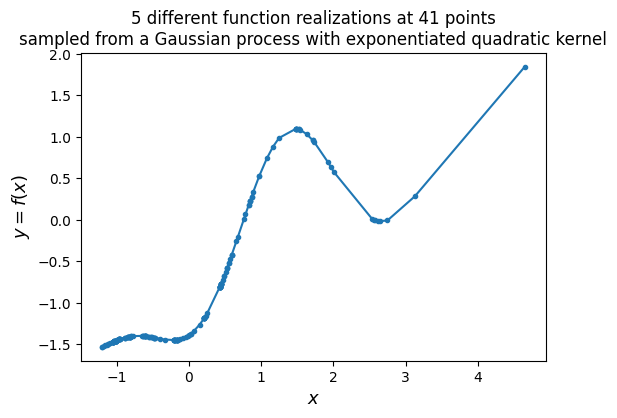

In [16]:
plt.figure(figsize=(6, 4))
for i in range(1):
    plt.plot(np.expand_dims(sorted(X_train_preprocessed[0:200, -3]), 1), ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.show()

## Model Training

### Model Selection functions

#### Random subsampling cross validation for Gaussian Process Regression

In [51]:
def random_subsampling_split(X_train, y_train, tst_size = 2000, tr_size = 1500, seed = 1):
    X_temp, X_cross_val, y_temp, y_cross_val = train_test_split(X_train, y_train, test_size=tst_size, shuffle=True, random_state=seed)
    X_train_sub, _, y_train_sub, _ = train_test_split(X_temp, y_temp, train_size=tr_size, shuffle=True, random_state=seed)
    return X_train_sub, X_cross_val, y_train_sub, y_cross_val

'''
Takes in:
- X
- y
- full_pipeline
- scoring

Returns:
- Array of scores from cross validation using random subsampling

We use this for Gaussian Process Regression because it isn't possible for GP regression to be trained on all training samples due to computational complexity.
We train on a subset of the training set of 1500 samples. We still evaluate on the same number of validation samples in cross validation to maintain comparability of the cv score with other models.
'''
def random_subsampling_cv(full_pipeline, X_train_cleaned, y_train_cleaned, scoring, model, train_size = 1500, numeric_cols_only = False, n_splits=10):
    cv_scores = []
    
    X_train_preprocessed = full_pipeline.fit_transform(X_train_cleaned, y_train_cleaned)
    
    if numeric_cols_only:
        X_train_preprocessed = X_train_preprocessed[:, -3:]
    
    for i in range(n_splits):
        X_train_sub, X_val_sub, y_train_sub, y_val_sub = random_subsampling_split(
                X_train_preprocessed, 
                y_train_cleaned, 
                tst_size=(len(X_train_preprocessed) // n_splits),
                tr_size=train_size,
                seed=i)

        model.fit(X_train_sub, y_train_sub)

        y_pred_val_sub = model.predict(X_val_sub)
        score = scoring(y_val_sub, y_pred_val_sub)
        cv_scores.append(score)
        print("Finished split:", i+1)
    
    return cv_scores

#### K-Fold Cross Validation

In [52]:
def k_fold_cross_validation(full_pipeline, X_train_cleaned, y_train_cleaned, scoring, model, numeric_cols_only = False, n_splits=10):
    X_train_preprocessed = full_pipeline.fit_transform(X_train_cleaned, y_train_cleaned)
    if numeric_cols_only:
        X_train_preprocessed = X_train_preprocessed[:, -3:]
        
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_preprocessed, y_train_cleaned, cv = cv, scoring=scoring)
    return -scores

#### Bayesian Model Evidence Based Selection

In [58]:
def bayesian_model_evidence_selection(full_pipeline, X_train_cleaned, y_train_cleaned, BayesianLinearRegressionClass, num_samples = 1000, num_models = 10, seed = 1):
    np.random.seed(seed)
    
    X_train_preprocessed = full_pipeline.fit_transform(X_train_cleaned, y_train_cleaned)
    
    param_indices = np.array([0,1,2,3,4,5])
    
    all_subsets = []
    all_evidences = []
    best_subset = []
    highest_evidence = -sys.maxsize - 1
    
    for i in range(num_models):
        subset_size = np.random.randint(1, len(param_indices))
        
        if i == 0:
            subset = [0,1,2,3,4,5]
        else:
            subset = np.random.choice(param_indices, subset_size, replace=False)
        subset = sorted(subset)
        
        blr = BayesianLinearRegressionClass(
                                mu_0=np.zeros(len(subset)+1),
                                a_0=0.01,
                                b_0=0.01,
                                fit_intercept=True,
                                unit_information_prior=True
                                )
        blr.fit(X_train_preprocessed[:num_samples,subset], y_train_cleaned[:num_samples])
        if blr.log_model_evidence > highest_evidence:
            highest_evidence = blr.log_model_evidence
            best_subset = subset
        
        all_subsets.append(subset)
        all_evidences.append(blr.log_model_evidence)
        
        print("Finished calculating evidence for subset number:", i+1)

    return highest_evidence, best_subset, all_evidences, all_subsets

### Model evaluation class

In [ ]:

class RegressionEvaluator(ABC):
    def __init__(self, model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names):
        self.model = model
        self.feature_names = feature_names
        self.real = y_evaluation_cleaned 
        self.preds = self.model.predict(X_evaluation_preprocessed[:, :])

    @abstractmethod
    def plot_coefficients(self):
        pass
    
    @abstractmethod
    def get_coefficient_statistics(self):
        pass
    
    def get_metrics(self):
        mse = mean_squared_error(self.real, self.preds)
        mae = mean_absolute_error(self.real, self.preds)
        r2_coefficient = r2_score(self.real, self.preds)
        return {
            'mse': mse,
            'mae': mae,
            'r2_coefficient': r2_coefficient
            }

            
    def plot_regression_plot(self):
        sns.regplot(x = self.real, y = self.preds, color='blue', scatter_kws={'alpha': 0.5}, line_kws={'color': 'maroon'})
        plt.plot([self.real.min(), self.real.max()], [self.real.min(), self.real.max()], 'k--', lw=2)
        plt.title('True Values against Predicted Values')
        plt.xlabel('True values', fontsize=14)
        plt.ylabel('Predicted values', fontsize=14)

        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Data', markerfacecolor='blue', markersize=8, alpha=0.5),
            Line2D([0], [0], color='maroon', lw=2, label='Regression Line'),
            Line2D([0], [0], color='k', lw=2, linestyle='--', label='45° Line (Ideal)')
        ]

        plt.legend(handles = legend_elements)
        plt.show()

    def plot_residual_plot(self):
        residuals = self.real - self.preds
        sns.residplot(x=self.preds, y=residuals, color='blue', scatter_kws={'alpha':0.5})
        plt.title('Residuals Plot')
        plt.xlabel('Predicted values', fontsize=14)
        plt.ylabel('Residuals', fontsize=14)
        plt.show()

    def get_all_regression_metrics(self):
        metrics = self.get_metrics()
        print(metrics)
        self.plot_coefficients()
        self.plot_regression_plot()
        self.plot_residual_plot()
        self.get_coefficient_statistics()

        
class BayesianLinearRegressionEvaluator(RegressionEvaluator):
    def __init__(self, model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names):
        super().__init__(model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names)
        
    def plot_coefficients(self):
        coefficients = self.model.coef_
        self.feature_names = pd.Index(['intercept']).append(self.feature_names)
        plt.bar(range(len(self.feature_names)), np.abs(coefficients))
        plt.xticks(range(len(self.feature_names)),self.feature_names[:len(self.feature_names)],rotation=-45)
        plt.xlabel('Coefficient')
        plt.ylabel('Absolute value - log scale')
        plt.yscale('log')
        plt.show()
    
    def get_coefficient_statistics(self):
        pd.set_option('display.width', None)
        pd.set_option('display.max_columns', None)
        print(self.model.get_summary().to_string())
        print()
        

class LinearRegressionEvaluator(RegressionEvaluator):
    def __init__(self, model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names, stats_model):
        self.stats_model = stats_model
        super().__init__(model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names)
        
    def plot_coefficients(self):
        coefficients = self.model.coef_
        plt.bar(range(len(self.feature_names)), np.abs(coefficients))
        plt.xticks(range(len(self.feature_names)),self.feature_names[:len(self.feature_names)],rotation=-45)
        plt.xlabel('Coefficient')
        plt.ylabel('Absolute value - log scale')
        plt.yscale('log')
        plt.show()
        
    def get_coefficient_statistics(self):
        results = self.stats_model.fit()
        print(results.summary())
        print()
    
class GaussianProcessRegressionEvaluator(RegressionEvaluator):
    def __init__(self, model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names):
        super().__init__(model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names)
        
    def _plot_coefficient_plotter(self, importance):
        plt.bar(range(len(self.feature_names)), np.abs(importance))
        plt.xticks(range(len(self.feature_names)),self.feature_names[:len(self.feature_names)],rotation=-45)
        plt.title("GP Feature Importance (1 / Length Scale)")
        plt.xlabel('Coefficient')
        plt.ylabel('Feature Importance (log scale)')
        plt.yscale('log')
        plt.show()
        
    def get_coefficient_statistics(self):
        return super().get_coefficient_statistics()
    
    def plot_coefficients(self):
        kernel_params = self.model.kernel_.get_params()
        length_scale_params = []
        for kp_key in kernel_params:
            if kp_key.endswith("length_scale"):
                length_scale_params.append(kp_key)
        
        for i in range(len(length_scale_params)):
            coefficients = kernel_params[length_scale_params[i]]
            if isinstance(coefficients, np.float64):
                print("Isotropic kernel with length_scale value:", coefficients)
                continue
            importance = 1 / coefficients
            self._plot_coefficient_plotter(importance)

### Gaussian Process Regression

#### Gaussian Process Regression using 1 covariate: Plotting the fit

Here, we are training a basic Gaussian Process regression model using quadratic exponential kernel on just 1 covariate (carat). We do this so we can visually see how Gaussian Process Regression actually works.
This section serves as a foundation for later more complex Gaussian Process models, which will utilize all covariates. We will not be able to visualize the fits of the regression in those cases.
We will also plot 95% confidence intervals across the fit.

In [305]:
kernel = ConstantKernel(constant_value=1,constant_value_bounds=(1e+1, 1e+10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 100)) + WhiteKernel(noise_level=1 ** 2, noise_level_bounds=(1e-5, 1e+10))
# kernel = ConstantKernel(constant_value=1,constant_value_bounds=(1e+1, 1e+10)) * ExpSineSquared(length_scale=1.0, periodicity=5.0) + WhiteKernel(noise_level=10000, noise_level_bounds=(1e-10, 1e+10))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


X_train_preprocessed_1500, _, y_train_cleaned_1500, _ = random_subsampling_split(X_train_preprocessed, y_train_cleaned, tr_size = 1500)
gp.fit(X_train_preprocessed_1500[:, -3:-2], y_train_cleaned_1500)
gp.kernel_

7.33e+03**2 * RBF(length_scale=1.56) + WhiteKernel(noise_level=2.07e+06)

In [306]:
# For the val set
y_preds_val_set, sigma_preds_val_set= gp.predict(
    X_val_preprocessed[:, -3:-2], 
    return_std=True
    )

# For all values in a linear space, best option for plotting.
X_linspace = np.expand_dims(np.linspace(-10, 10, 10000), 1)
y_preds_linspace, sigma_preds_linspace= gp.predict(
    X_linspace, 
    return_std=True
    )

Mean Squared Error: 2237715.4186076587
Mean Absolute Error: 842.9939953254088
R2 coefficient 0.8439652356474457


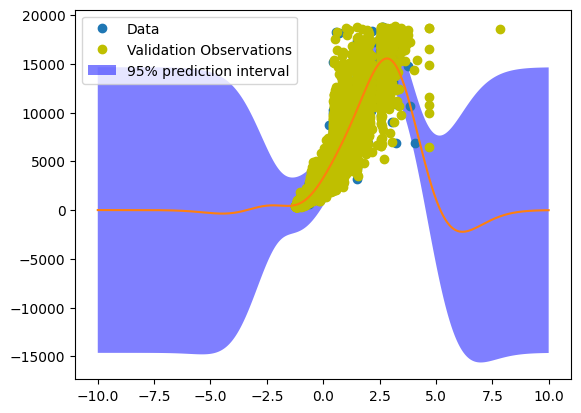

In [307]:
mse = mean_squared_error(y_preds_val_set, y_val_cleaned)
mae = mean_absolute_error(y_preds_val_set, y_val_cleaned)
r2 = r2_score(y_preds_val_set, y_val_cleaned)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 coefficient", r2)

plt.plot(X_train_preprocessed_1500[:, -3], y_train_cleaned_1500, 'o', label = 'Data')
plt.plot(X_val_preprocessed[:, -3], y_val_cleaned, 'yo', label='Validation Observations')
plt.plot(X_linspace, y_preds_linspace)
plt.fill(
    np.concatenate([X_linspace, X_linspace[::-1]]),
    np.concatenate(
        [y_preds_linspace - 1.9600 * sigma_preds_linspace,
        (y_preds_linspace + 1.9600 * sigma_preds_linspace)[::-1]]),
    alpha=.5, fc='b', ec='None', label='95% prediction interval'
)
plt.legend(loc='upper left')
plt.show()

#### Cross-validation to find best Gaussian Process Kernel

Here we will do cross-validation via subsampling within the training set to find the best Gaussian Process model. The Gaussian Process model is fitted on all covariates. We then take the model with the lowest average MSE across all splits (10 splits). The reason we do the subsampling approach instead of k-fold approach is because Gaussian Process models are prohibited by the number of data points due to the algorithm's computational time complexity. We sample 1500 points from the training split, and then validate on unseen validation split in each fold.

NOTE: I tried many more models, but to save time and space have presented results of only 2 models. The best results were achieved by the isotropic RBF kernel

Note: Below cell took ~20 mins to run on Apple MacBook M1 Air

In [323]:
kernel = ConstantKernel(constant_value=1,constant_value_bounds=(1e+1, 1e+10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 100)) + WhiteKernel(noise_level=1 ** 2, noise_level_bounds=(1e-5, 1e+10))
gp_rbf = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

cv_scores_gp_rbf_all_cols = random_subsampling_cv(full_pipeline, X_train_cleaned, y_train_cleaned, mean_squared_error, gp_rbf, train_size = 1500, numeric_cols_only=False)
print(cv_scores_gp_rbf_all_cols)
print(np.mean(cv_scores_gp_rbf_all_cols))

Finished split: 1
Finished split: 2
Finished split: 3
Finished split: 4
Finished split: 5
Finished split: 6
Finished split: 7
Finished split: 8
Finished split: 9
Finished split: 10
[552650.8893371747, 486787.75937934493, 576570.4166683359, 426541.10354817094, 536044.6171981241, 402474.0654139659, 433002.29536201444, 451477.3978757107, 495388.59724623983, 423395.5633621283]
478433.27053912095


Note: Below cell took ~40 mins to run on Apple MacBook M1 Air

In [329]:
kernel = ConstantKernel(constant_value=1,constant_value_bounds=(1e+1, 1e+10)) * RationalQuadratic(length_scale=1.0, alpha=1.0) + WhiteKernel(noise_level=1 ** 2, noise_level_bounds=(1e-5, 1e+10))
gp_rq = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

cv_scores_gp_rq_all_cols = random_subsampling_cv(full_pipeline, X_train_cleaned, y_train_cleaned, mean_squared_error, gp_rq, train_size = 1500, numeric_cols_only=False)
print(cv_scores_gp_rq_all_cols)
print(np.mean(cv_scores_gp_rq_all_cols))

Finished split: 1
Finished split: 2
Finished split: 3
Finished split: 4
Finished split: 5


KeyboardInterrupt: 

#### Refitting best Gaussian Process model on entire training set and seeing performance on Validation Set

##### Refitting Gaussian on entire training set and evaluating fit

In [62]:
#kernel = ConstantKernel(constant_value=1,constant_value_bounds=(1e+1, 1e+10)) * RBF(length_scale=[1.0] * len(X_val_preprocessed[0]), length_scale_bounds=(1e-5, 100)) + WhiteKernel(noise_level=1 ** 2, noise_level_bounds=(1e-5, 1e+10))
kernel = ConstantKernel(constant_value=1,constant_value_bounds=(1e+1, 1e+10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 100)) + WhiteKernel(noise_level=1 ** 2, noise_level_bounds=(1e-5, 1e+10))
#kernel = ConstantKernel(constant_value=1,constant_value_bounds=(1e+1, 1e+10)) * RationalQuadratic(length_scale=1.0, alpha=1.0) + WhiteKernel(noise_level=1 ** 2, noise_level_bounds=(1e-5, 1e+10))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
X_train_preprocessed_1500, _, y_train_cleaned_1500, _ = random_subsampling_split(X_train_preprocessed, y_train_cleaned, tr_size = 1500)
gp.fit(X_train_preprocessed_1500[:, :], y_train_cleaned_1500)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

{'mse': 535075.2082500568, 'mae': 392.45609509169594, 'r2_coefficient': 0.9659363852362877}
Isotropic kernel with length_scale value: 4.877010167621725


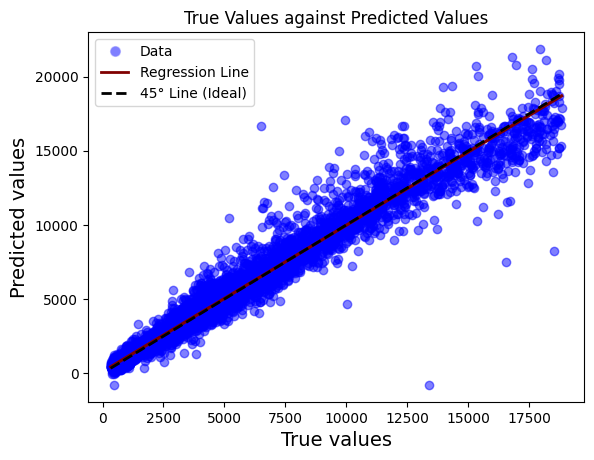

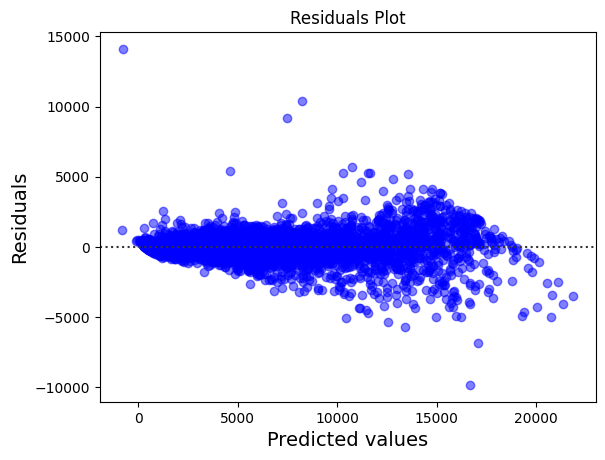

In [66]:
regression_evaluator_gp = GaussianProcessRegressionEvaluator(model=gp, X_evaluation_preprocessed=X_val_preprocessed, y_evaluation_cleaned=y_val_cleaned, feature_names = X_train_cleaned.columns)
regression_evaluator_gp.get_all_regression_metrics()

### Linear regression

#### Cross validation
In Standard Linear Regression, we aren't tuning any hyperparameters apart from choosing the amount of covariates. Removing any single covariate resulted in a loss of performance according to MSE. In addition, all coefficients are statistically significant according to t-tests conducted by the statsmodel package.

I have shown the cross-validation results below of the model with all covariates

In [24]:
cv_scores_lr_all_cols = k_fold_cross_validation(full_pipeline, X_train_cleaned, y_train_cleaned, 'neg_mean_squared_error', LinearRegression(), numeric_cols_only=False, n_splits=10)
print(cv_scores_lr_all_cols)

[1445278.9486 1579344.5305 1702332.4103 1573463.9140 1433696.6845
 1403158.1263 1395964.7283 1726481.0989 1602182.6322 1544329.1433]


#### Refitting Linear Regression model on entire training set and seeing performance on Validation Set

In [25]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_preprocessed[:, :], y_train_cleaned)

LinearRegression()

{'mse': 1491647.9243108593, 'mae': 858.1428999863338, 'r2_coefficient': 0.9050396664368149}


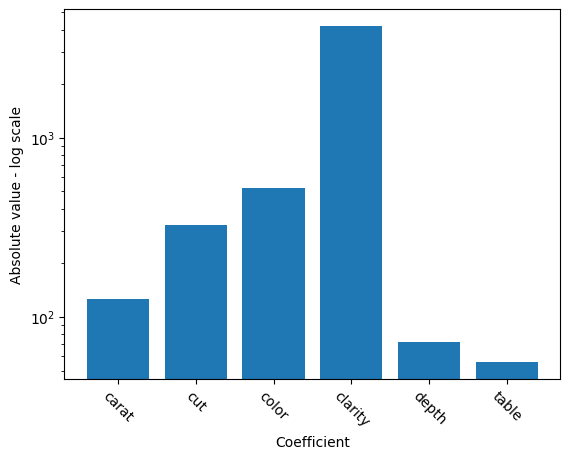

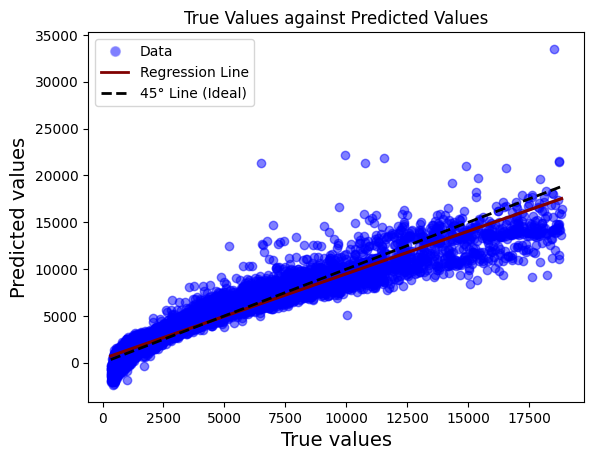

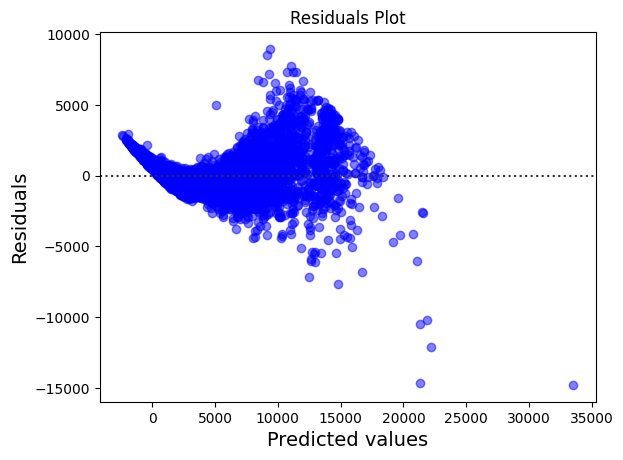

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 1.590e+04
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:29:07   Log-Likelihood:                -85098.
No. Observations:                9982   AIC:                         1.702e+05
Df Residuals:                    9975   BIC:                         1.703e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        886.2987     54.186     16.357      0.0

In [26]:
regression_evaluator_lr = LinearRegressionEvaluator(model=lr, 
                                                    X_evaluation_preprocessed=X_val_preprocessed, 
                                                    y_evaluation_cleaned=y_val_cleaned, 
                                                    feature_names = X_train_cleaned.columns,
                                                    stats_model=sm.OLS(y_val_cleaned, sm.add_constant(X_val_preprocessed[:, :])))
regression_evaluator_lr.get_all_regression_metrics()

### Bayesian Linear Regression

In [54]:
class BayesianLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, omega_0 = [[1.0]], mu_0 = [0], a_0 = 0.01, b_0 = 0.01, fit_intercept = True, unit_information_prior = True):
        self.omega_0 = omega_0 
        self.omega_0_inv = sc.linalg.inv(self.omega_0)
        self.mu_0 = mu_0
        self.a_0 = a_0
        self.b_0 = b_0
        self.fit_intercept = fit_intercept
        self.unit_information_prior = unit_information_prior

        
    def _calculate_posteriors(self, X, y):
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        
        XtX = X.T @ X
        n, p = X.shape

        if self.unit_information_prior:
            self.omega_0 = n * sc.linalg.inv(X.T @ X)
            self.omega_0_inv = sc.linalg.inv(self.omega_0)
        
        self.omega_n = sc.linalg.inv(XtX + self.omega_0_inv)
        self.mu_n = self.omega_n @ (self.omega_0_inv @ self.mu_0 + X.T @ y)
        self.a_n = self.a_0 + n/2
        
        term2 = y.T @ y + self.mu_0.T @ self.omega_0_inv @ self.mu_0 + self.mu_n.T @ sc.linalg.inv(self.omega_n) @ self.mu_n
        self.b_n = self.b_0 + term2/2

    def _get_marginal_t_distribution(self, mu, Sigma, j, nu):
        sigma_j2 = Sigma[j, j]
        return t(df = nu, loc=mu[j], scale = np.sqrt(sigma_j2))
    
    # y ~ N(XB, sigma^2 * I_n)
    # p(y|B, sigma^2, X)
    def __calculate_log_likelihood(self, X, y):
        n, p = X.shape
        # The variance of the residuals is distributed according to inverse gamma distribution
        # The posterior params are a_n, b_n
        sigma2 = self.b_n / (self.a_n - 1) # The mean of inverse gamma with params a, b is b / (a - 1)
        cov = sigma2 * np.eye(n)
        beta = self.mu_n
        mu = X @ beta
        log_likelihood = multivariate_normal.logpdf(y,mu,cov) # Note this line will struggle to when n > 10,000 due to 10,000x10,000 covariance matrix
        return log_likelihood
    
    def __calculate_log_prior(self):
        sigma2 = self.b_n / (self.a_n - 1)
        beta = self.mu_n
        log_prior = self.a_0 * np.log(self.b_0) - loggamma(self.a_0) - (self.a_0 + 1) * np.log(sigma2) - self.b_0 / sigma2
        log_prior = log_prior + multivariate_normal.logpdf(beta,self.mu_0,sigma2*self.omega_0)
        return log_prior
    
    def __calculate_log_posterior(self):
        sigma2 = self.b_n / (self.a_n - 1)
        beta = self.mu_n
        log_posterior = self.a_n * np.log(self.b_n) - loggamma(self.a_n) - (self.a_n + 1) * np.log(sigma2) - self.b_n / sigma2
        log_posterior = log_posterior + multivariate_normal.logpdf(beta,self.mu_n,sigma2*self.omega_n)
        return log_posterior
         
    def _calculate_model_evidence(self, X, y):
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        log_likelihood = self.__calculate_log_likelihood(X, y)
        log_prior = self.__calculate_log_prior()
        log_posterior = self.__calculate_log_posterior()
        log_model_evidence = log_likelihood + log_prior - log_posterior
        return log_model_evidence   
    
    
    def get_summary(self):
        check_is_fitted(self)
        
        scale = (self.b_n / self.a_n) * self.omega_n
        lower5_t = []
        upper5_t = []
        for i in range(0, len(scale)):
            marginal = self._get_marginal_t_distribution(self.mu_n, scale, i, 2 * self.a_n)
            lower, upper = marginal.ppf([0.025, 0.975])
            lower5_t.append(lower)
            upper5_t.append(upper)
        lower5_t = np.array(lower5_t)
        upper5_t = np.array(upper5_t)

        np.random.seed(1)
        betas = multivariate_t.rvs(loc = self.mu_n, shape=scale, df=2 * self.a_n, size=10000000)
        lower5_sampling = np.percentile(betas, 2.5, axis=0)
        upper5_sampling = np.percentile(betas, 97.5, axis=0)
        results = np.column_stack([self.mu_n, lower5_sampling, upper5_sampling, lower5_t, upper5_t])
        summary = pd.DataFrame(results, columns=['posterior mean','lower 95% bound (Monte Carlo Sampling)',
                                                 'upper 95% bound (Monte Carlo Sampling)',
                                                 'lower 95% bound (t-dist value)',
                                                 'upper 95% bound (t-dist value)'], 
                               index=[f'x{j+1}' for j in range(len(scale))])
        return summary
        

    def fit(self, X, y):
        X, y = check_X_y(X, y)
            
        self._calculate_posteriors(X, y)
        self.coef_ = self.mu_n
        self.log_model_evidence = self._calculate_model_evidence(X, y)
        return self
        
        
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        return X @ self.mu_n

#### Bayesian Model Evidence
For the Bayesian Linear Regression model, I decided to choose the number of covariates according to the highest marginal likelihood. I used the unit information prior with mean 0. This way we automatically choose a model while optimizing parsimony as opposed to optimizing predictive power, and seeing if this approach is able to significantly reduce the error on the validation set using this alternative approach.

One thing to note is calculating the likelihood is computationally extremely difficult when $n \geq 10000$ (The covariance matrix is of this dimension), and this is necessary to calculate the marginal likelihood. Hence we are limited to training on a subset of the training dataset of size 10,000.

NOTE: The below cell took 30 mins to run


In [55]:

best_evidence, best_feature_subset, _, _ = bayesian_model_evidence_selection(full_pipeline, 
                                                                            X_train_cleaned, 
                                                                            y_train_cleaned, 
                                                                            BayesianLinearRegression,
                                                                            num_samples=10000,
                                                                            num_models=10,
                                                                            )

print("Best Model Evidence:", best_evidence)
print("Best Feature Subset:", best_feature_subset)

Best Model Evidence: -99069.83997958271
Best Feature Subset: [2, 3]


#### Refitting model with highest marginal likelihood on the training set and evaluating performance on validation

In [59]:
blr = BayesianLinearRegression(
                               mu_0=np.zeros(len(best_feature_subset)+1),
                               a_0=0.01,
                               b_0=0.01,
                               fit_intercept=True,
                               unit_information_prior=True
                               )

num_samples_blr = 10000
blr.fit(X_train_preprocessed[:num_samples_blr,best_feature_subset], y_train_cleaned[:num_samples_blr])

BayesianLinearRegression(mu_0=array([0.0000, 0.0000, 0.0000]),
                         omega_0=array([[4.8893, -1.2769, -0.7151],
       [-1.2769, 0.4192, 0.2361],
       [-0.7151, 0.2361, 1.1371]]))

{'mse': 1782904.3489011952, 'mae': 912.3536848597455, 'r2_coefficient': 0.8864978867173835}


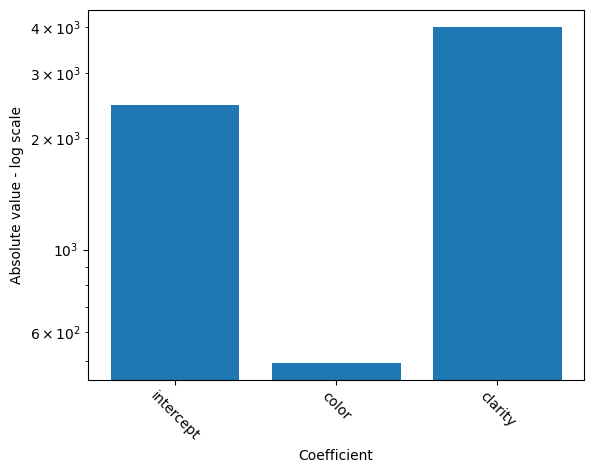

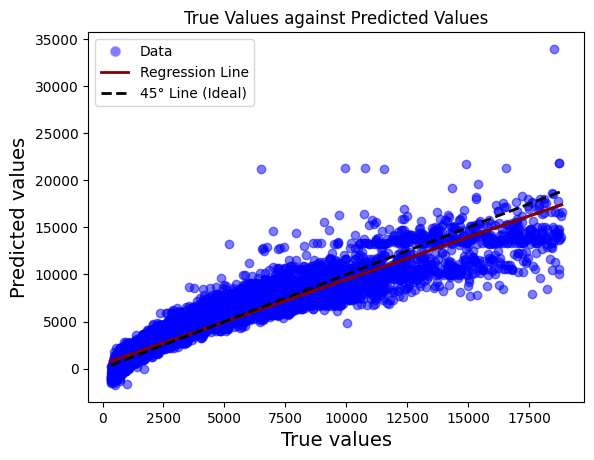

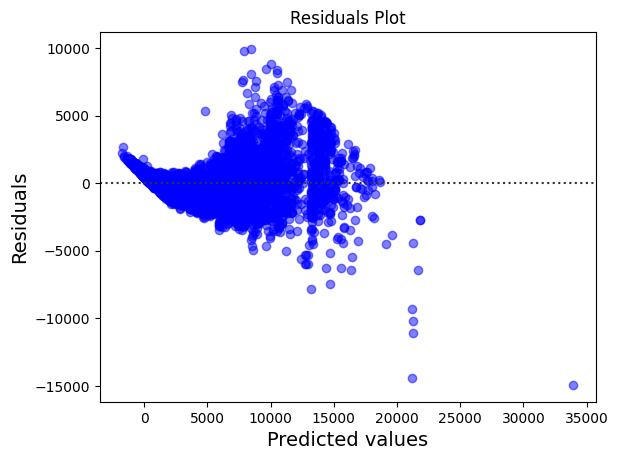

    posterior mean  lower 95% bound (Monte Carlo Sampling)  upper 95% bound (Monte Carlo Sampling)  lower 95% bound (t-dist value)  upper 95% bound (t-dist value)
x1     2462.854252                             2121.650978                             2803.959011                     2121.708910                     2803.999594
x2      494.442065                              394.556872                              594.293723                      394.548315                      594.335816
x3     4006.326215                             3841.733963                             4170.930400                     3841.809383                     4170.843046



In [60]:
regression_evaluator_blr = BayesianLinearRegressionEvaluator(model=blr, 
                                                    X_evaluation_preprocessed=X_val_preprocessed[:, best_feature_subset], 
                                                    y_evaluation_cleaned=y_val_cleaned, 
                                                    feature_names = X_train_cleaned.columns[best_feature_subset],
                                                    )
regression_evaluator_blr.get_all_regression_metrics()

## Final Model Evaluation

The best model we found was the isotropic Gaussian Process Regressor. This gave a validation MSE of around 540,000. The error on the test set is lower than the validation, of around 510,000. This model marks a signicant improvement compared to Linear Regression and Bayesian Linear Regression models, highlighting the non-linear structure of the underlying data. This has successfully been captured by a Gaussian Process Regressor

{'mse': 518373.5111184509, 'mae': 395.51893768780366, 'r2_coefficient': 0.9672942716871121}
Isotropic kernel with length_scale value: 4.877010167621725


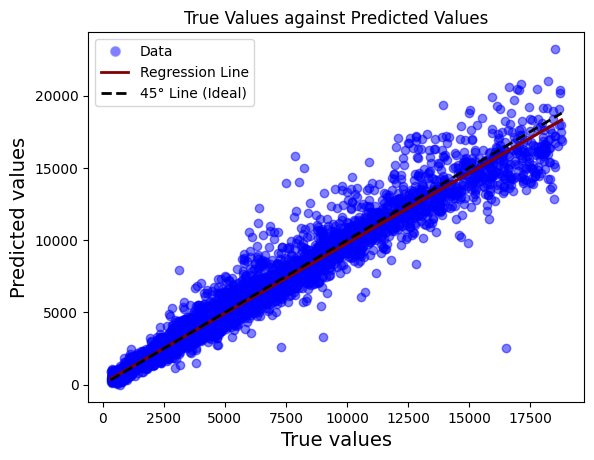

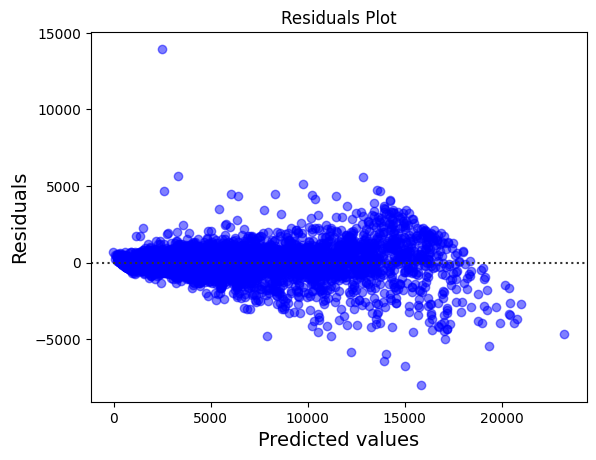

In [67]:
regression_evaluator_gp_test_set = GaussianProcessRegressionEvaluator(model=gp, X_evaluation_preprocessed=X_test_preprocessed, y_evaluation_cleaned=y_test_cleaned, feature_names = X_train_cleaned.columns)
regression_evaluator_gp_test_set.get_all_regression_metrics()